# Teacher's Assignment No. 14 - Q2

***Author:*** *Ofir Paz* $\qquad$ ***Version:*** *15.05.2024* $\qquad$ ***Course:*** *22961 - Deep Learning*

Welcome to question 2 of the fourth assignment of the course *Deep Learning*. \
In this question, we will implement the *DropNorm* network layer, and compare the use of this layer to the normal dropout and normalizing layers in pytorch with training on *Fashion-MNIST*

## Imports

First, we will import the required packages for this assignment.
- [pytorch](https://pytorch.org/) - One of the most fundemental and famous tensor handling library.
- [numpy](https://numpy.org) - The fundamental package for scientific computing with Python.
- [matplotlib](https://matplotlib.org) - Library to plot graphs in Python.

In [1]:
from typing import Tuple
import torch  # pytorch.
import torch.nn as nn  # neural network module.
import torch.nn.functional as F  # functional module.
import torch.optim as optim  # optimizer module.
from torch.utils.data import DataLoader  # data loader.
from torchvision import datasets, transforms  # torchvision, for datasets.
from torchmetrics import Accuracy  # accuracy metric.
import matplotlib.pyplot as plt  # plotting.

## DropNorm Implementation

We will start with the implementation of the *DropNorm* layer, using pytorch.

In [15]:
class DropNorm(nn.Module):
    '''DropNorm layer.
    
    The DropNorm layer is a combined dropout and batch norm layers that in training mode
    zeros half of the input tensor and normalizes the other half. In evaluation mode, it
    normalizes the entire input tensor.
    '''
    def __init__(self, num_features: int) -> None:
        '''
        Constructor for the DropNorm layer.

        Args:
            num_features (int) - number of features to work on.
        '''
        super(DropNorm, self).__init__()
        
        self.gammas = nn.Parameter(torch.zeros(num_features))
        self.betas = nn.Parameter(torch.ones(num_features))
        self.eps = 1e-6
        self.p = 0.5

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Forward pass of the layer.

        Args:
            x (torch.Tensor) - Input tensor. Assumes shape (batch_size, #features, ...).

        Returns:
            torch.Tensor - Output tensor.
        '''

        gammas = self.gammas.view(1, self.gammas.size(0), *((1,) * (x.dim() - 2)))
        betas = self.betas.view(1, self.betas.size(0), *((1,) * (x.dim() - 2)))

        if self.training:
            mask = torch.bernoulli(torch.full(x.shape, self.p)).to(x.device)
            x = x * mask

        x_mean = x.mean(dim=0, keepdim=True)
        x_var = x.var(dim=0, keepdim=True)
        x = (x - x_mean) / torch.sqrt(x_var + self.eps)
        x = x * gammas + betas
        
        if self.training:
            x = x * mask
                
        return x

## Training Network on Fashion-MNIST

In [3]:
# Configure hyper parameters.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 1024 if device == 'cuda' else 256

# Load the Fashion-MNIST dataset.

# Define the transformations.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Load the dataset.
train_set = datasets.FashionMNIST('data', download=True, train=True, transform=transform)
val_set = datasets.FashionMNIST('data', download=True, train=False, transform=transform)

# Prepare the data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

Next code snippet introduces the `BaseModel` class, which will serve as a base model for the two networks that we need to implement. 

In [4]:
class BaseModel(nn.Module):
    '''Base model class.'''
    def __init__(self) -> None:
        '''Constructor.'''
        super(BaseModel, self).__init__()
        self.best_weights = []
        self.epoch: int = 0
        self.costs: list[float] = []
        self.train_accs: list[float] = []
        self.val_accs: list[float] = []

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''Forward pass.'''
        raise NotImplementedError
    
    def fit(self, train_loader: DataLoader, val_loader: DataLoader,
            num_epochs: int = 30, lr: float = 0.001, wd: float = 0., 
            try_cuda: bool = True, quite: bool = False, print_stride: int = 1) -> None:
        '''
        Base function for training the model.

        Args:
            train_loader (DataLoader) - The dataloader to fit the model to.
            val_loader (DataLoader) - The dataloader to validate the model on.
            num_epochs (int) - Number of epochs.
            lr (float) - Learning rate.
            wd (float) - Weight decay.
            try_cuda (bool) - Try to use CUDA.
            quite (bool) - Quite mode.
            print_stride (int) - Print stride (in epochs).
        '''
        use_cuda = try_cuda and torch.cuda.is_available()
        if use_cuda:
            self.cuda()
            print("Using CUDA for traininig.")
        else:
            self.cpu()
            print("Using CPU for training.")

        # Create the optimizer and criterion.
        optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=wd)
        criterion = nn.CrossEntropyLoss()

        start_epoch = self.epoch
        for epoch in range(num_epochs):
            train_true = 0.
            running_loss = 0.
            self.epoch += 1
            for mb, (x, y) in enumerate(train_loader):
                if use_cuda:
                    x, y = x.cuda(), y.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                y_hat = self(x)

                loss = criterion(y_hat, y)
                loss.backward()
                optimizer.step()

                # Calc loss
                lloss = loss.item()
                running_loss += lloss * x.size(0)

                # Calc accuracy
                train_true += (y_hat.argmax(1) == y).sum().item()

                if not quite:
                    print(f"\r[epoch: {self.epoch:02d}/{start_epoch + num_epochs:02d}", end=" ")
                    print(f"mb: {mb + 1:03d}/{len(train_loader):03d}]", end=" ")
                    print(f"loss: {lloss:.6f}", end="")

            epoch_loss = running_loss / len(train_loader.dataset)  # type: ignore
            train_acc = train_true / len(train_loader.dataset)  # type: ignore
            val_acc = self.calc_acc(val_loader, use_cuda)
            self.save_best_weights(val_acc)
            self.costs.append(epoch_loss)
            self.train_accs.append(train_acc)
            self.val_accs.append(val_acc)
                
            if not quite and (epoch % print_stride == 0 or epoch == num_epochs - 1):
                print(f"\r[epoch: {self.epoch:02d}/{start_epoch + num_epochs:02d}]", end=" ")
                print(f"[Total Loss: {epoch_loss:.6f}]", end=" ")
                print(f"[Train Acc: {100 * train_acc:.3f}%]", end=" ")
                print(f"[Val Acc: {100 * val_acc:.3f}%]")

    
    def calc_acc(self, data_loader: DataLoader, use_cuda: bool) -> float:
        '''
        Calculates and returns the accuracy of the model on a give dataset.

        Args:
            data_loader (DataLoader) - Data loader.
            use_cuda (bool) - Use CUDA flag.
        '''
        
        accuracy = Accuracy(task="multiclass", num_classes=10)
        if use_cuda:
            accuracy = accuracy.cuda()
        self.eval()
        acc = 0.
        with torch.no_grad():
            for x, y in data_loader:
                if use_cuda:
                    x, y = x.cuda(), y.cuda()
                y_hat = self(x)
                acc += accuracy(y_hat, y).item() * x.size(0)
        
        self.train()
        return acc / len(data_loader.dataset)  # type: ignore
    
    def save_best_weights(self, val_acc: float) -> None:
        '''Saves the best weights of the model.'''
        if not self.best_weights:
            for p in self.parameters():
                self.best_weights.append(p.detach().clone())
        elif val_acc > max(self.val_accs):
            for i, p in enumerate(self.parameters()):
                self.best_weights[i].data = p.detach().clone()

    def load_best_weights(self) -> None:
        '''Loads the best weights of the model.'''
        for i, p in enumerate(self.parameters()):
            p.data = self.best_weights[i].clone()

In [5]:
class NormalNet(BaseModel):
    '''Normal Net
    A simple CNN that utilizes batch normalization and dropout.
    '''
    def __init__(self) -> None:
        super(NormalNet, self).__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.Dropout(0.5),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 80),
            nn.Dropout(0.5),
            nn.BatchNorm1d(80),
            nn.ReLU(inplace=True),
            nn.Linear(80, 10))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [6]:
# Use normal net to train the model.
normal_model = NormalNet()

# Train the model.
normal_model.fit(train_loader, val_loader, num_epochs=10, lr=0.0015, wd=0.0005, 
                 try_cuda=True, print_stride=1)

Using CUDA for traininig.
[epoch: 01/10] [Total Loss: 1.110984] [Train Acc: 69.757%] [Val Acc: 84.010%]
[epoch: 02/10] [Total Loss: 0.483807] [Train Acc: 86.207%] [Val Acc: 88.030%]
[epoch: 03/10] [Total Loss: 0.368602] [Train Acc: 88.795%] [Val Acc: 89.290%]
[epoch: 04/10] [Total Loss: 0.320551] [Train Acc: 90.072%] [Val Acc: 90.050%]
[epoch: 05/10] [Total Loss: 0.290001] [Train Acc: 90.927%] [Val Acc: 90.820%]
[epoch: 06/10] [Total Loss: 0.263487] [Train Acc: 91.707%] [Val Acc: 90.810%]
[epoch: 07/10] [Total Loss: 0.244712] [Train Acc: 92.037%] [Val Acc: 91.020%]
[epoch: 08/10] [Total Loss: 0.230899] [Train Acc: 92.558%] [Val Acc: 90.970%]
[epoch: 09/10] [Total Loss: 0.219401] [Train Acc: 92.878%] [Val Acc: 91.030%]
[epoch: 10/10] [Total Loss: 0.207634] [Train Acc: 93.218%] [Val Acc: 91.190%]


In [16]:
class CostumeNet(BaseModel):
    '''Costume Net model.
    Same as the NormalNet mode but with DropNorm layer.
    '''
    def __init__(self) -> None:
        super(CostumeNet, self).__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            DropNorm(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 80),
            DropNorm(80),
            nn.ReLU(inplace=True),
            nn.Linear(80, 10))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [17]:
# Train the model.
costume_model = CostumeNet()

costume_model.fit(train_loader, val_loader, num_epochs=10, lr=0.0015, wd=0.0005, 
                  try_cuda=True, print_stride=1)

Using CUDA for traininig.
[epoch: 01/10] [Total Loss: 2.316141] [Train Acc: 11.208%] [Val Acc: 77.760%]
[epoch: 02/10] [Total Loss: 1.987253] [Train Acc: 39.112%] [Val Acc: 82.850%]
[epoch: 03/10] [Total Loss: 1.184585] [Train Acc: 71.750%] [Val Acc: 84.850%]
[epoch: 04/10] [Total Loss: 0.651582] [Train Acc: 83.918%] [Val Acc: 88.410%]
[epoch: 05/10] [Total Loss: 0.462419] [Train Acc: 87.563%] [Val Acc: 89.420%]
[epoch: 06/10] [Total Loss: 0.377727] [Train Acc: 89.047%] [Val Acc: 90.240%]
[epoch: 07/10] [Total Loss: 0.329822] [Train Acc: 90.310%] [Val Acc: 89.730%]
[epoch: 08/10] [Total Loss: 0.306329] [Train Acc: 90.733%] [Val Acc: 90.760%]
[epoch: 09/10] [Total Loss: 0.282760] [Train Acc: 91.273%] [Val Acc: 90.730%]
[epoch: 10/10] [Total Loss: 0.265401] [Train Acc: 91.717%] [Val Acc: 91.000%]


## Results Comparison

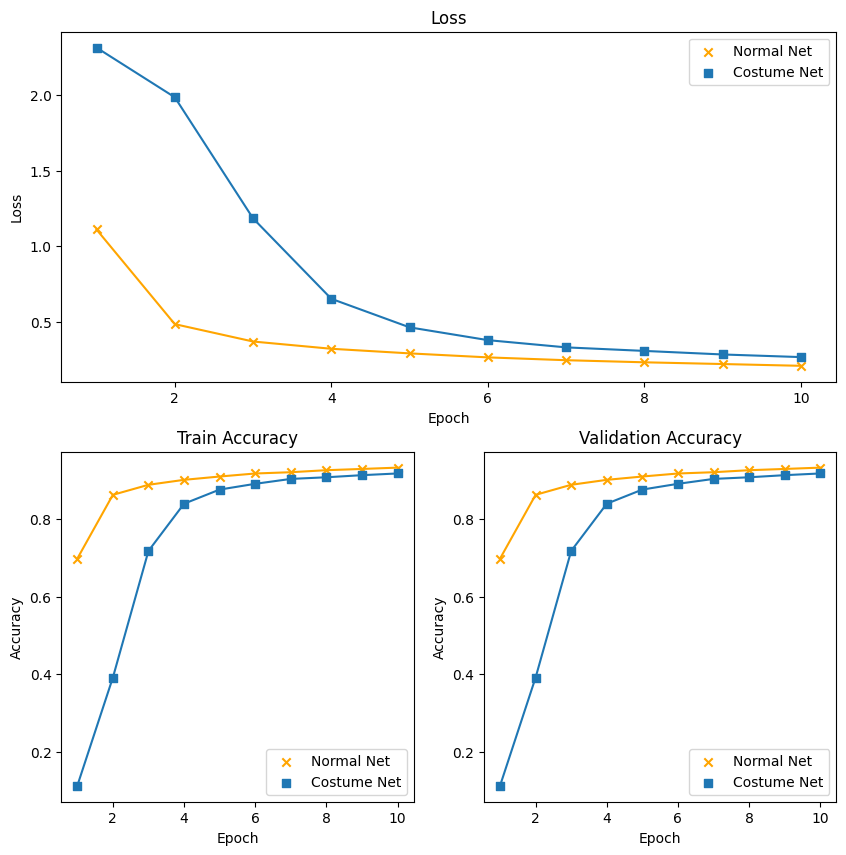

In [18]:
# Results comparison

# Plot the results.
def plot_and_scatter(epochs: range, points: list[float], label: str, 
                     color: str = "tab:blue", marker: str = "x") -> None:
    '''Plots the points and scatters them.'''
    plt.plot(epochs, points, color=color)
    plt.scatter(epochs, points, marker=marker, color=color, label=label)

epochs = range(1, costume_model.epoch + 1, 1)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plot_and_scatter(epochs, normal_model.costs, "Normal Net", "orange", marker="x")
plot_and_scatter(epochs, costume_model.costs, "Costume Net", "tab:blue", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")

plt.subplot(2, 2, 3)
plot_and_scatter(epochs, normal_model.train_accs, label="Normal Net", color="orange", marker="x")
plot_and_scatter(epochs, costume_model.train_accs, label="Costume Net", color="tab:blue", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Train Accuracy")

plt.subplot(2, 2, 4)
plot_and_scatter(epochs, normal_model.train_accs, label="Normal Net", color="orange", marker="x")
plot_and_scatter(epochs, costume_model.train_accs, label="Costume Net", color="tab:blue", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")

plt.show()

We can see that the costume net diverges at the beginning of the training, I think it is probably due to unoptimized initialization that pytorch handles better. A hint for that is the similar converges and that in this implementation the dropout zeros elements also after the batch norm. Though, the normal implementation does yield better performance. In general, it is better to not combine the batch normalization and dropout layers together since sometimes you might want to use one without the other. For example, it's not a good practice to use dropout between convolutional layers, but it's very wise to use batch normalization there.